In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Imports

In [3]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint

In [5]:
from transformers import BertTokenizer, BertModel

In [6]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate
from classes.preprocessing import load_data

## Primary Variables

Filepath variables

In [7]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [8]:
LOWER: bool = True
PADDING: str = "post"

nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training variables

In [9]:
INITIAL_LR: float = 2e-5
EPOCHS: int = 40
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256

DROPOUT: float = 0.25

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [10]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [11]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [12]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [13]:
def tokenize_data(tokenizer: Tokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int = None) ->typing.Tuple[typing.List[str], typing.List[str]]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = tokenizer.texts_to_sequences(premises)
  hypotheses = tokenizer.texts_to_sequences(hypotheses)

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING)

  return (premises, hypotheses)

In [14]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [15]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().replace(string.punctuation,"") for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = [" ".join(sentence) for sentence in sentences]
  return sentences


In [16]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [17]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [18]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [33]:
train_labels = np.array(train_labels, float).reshape(len(train_labels),1)
dev_labels = np.array(dev_labels, float).reshape(len(dev_labels),1)

In [20]:
#Removes stop words, punctuation, reduces to lower case
train_premises = clean_sentences(sentences=train_premises)
train_hypotheses = clean_sentences(sentences=train_hypotheses)

dev_premises = clean_sentences(sentences=dev_premises)
dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [21]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: it is constrained by laws and regulations formulated by congress over more than two centuries.
Hypothesis: many of the laws and regulations are obsolete by now.
Label: ['1']


## Tokenize Data

In [22]:
tokenizer = Tokenizer(lower=LOWER) #Automatically sets sentence to lower & removes punctuation
tokenizer.fit_on_texts(train_premises + train_hypotheses + dev_premises + dev_hypotheses)

In [23]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=train_premises, hypotheses=train_hypotheses)
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=dev_premises, hypotheses=dev_hypotheses)

In [24]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 40421


### Example

In [25]:
#Premise
print(f"Sentence: {tokenizer.sequences_to_texts([train_premises[index]])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['it is constrained by laws and regulations formulated by congress over more than two centuries']
Tokens: [   10     7 11670    25  1087     4  1316 14859    25   400    85    50
    76    67  1104     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [26]:
#Hypothesis
print(f"Sentence: {tokenizer.sequences_to_texts([train_hypotheses[index]])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['many of the laws and regulations are obsolete by now']
Tokens: [  88    3    1 1087    4 1316   15 9551   25   90    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## Embedding Matrix

In [27]:
### Will use word2vec to create an embedding matrix
EMBEDDING_SIZE = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_SIZE))

nltk.download('punkt')
word2vec = api.load('word2vec-google-news-300')

for word, index in tokenizer.word_index.items():
  try:
      embedding_matrix[index, :] = word2vec[word]
  except KeyError:
    pass
print(f"Embeddings shape: {embedding_matrix.shape}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Embeddings shape: (40421, 300)


# Experiment: Word2Vec Embeddings

In [28]:
model_name = "word2vec_embed"

## Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     1212630   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1024)                 3330048   ['embedding[0][0]',       

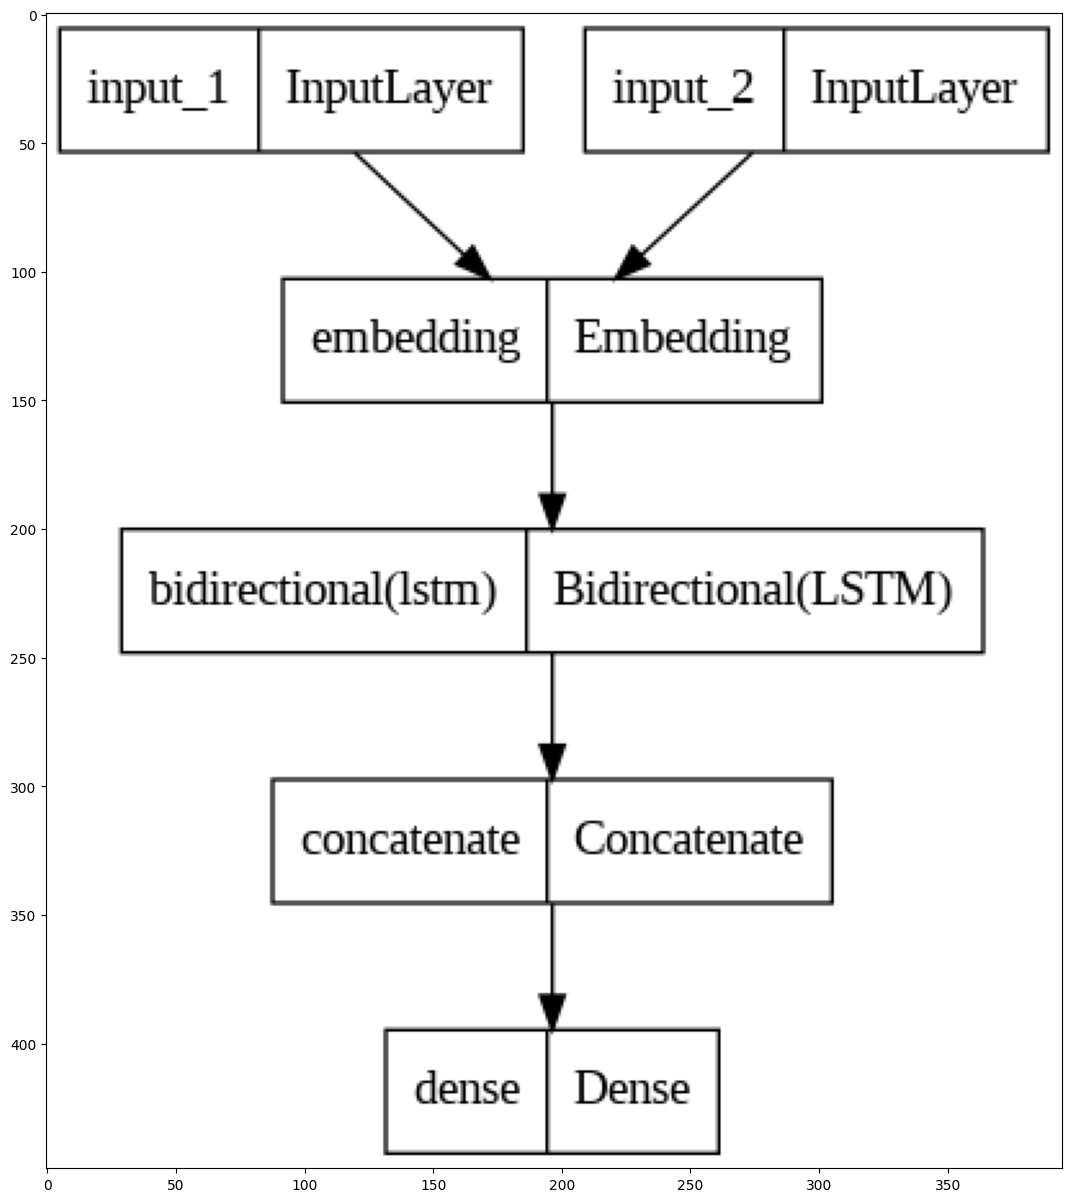

In [29]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=True)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

output_layer = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/40
85/85 [==============================] - 22s 172ms/step - loss: 0.6899 - accuracy: 0.5451 - val_loss: 0.6869 - val_accuracy: 0.5394
Epoch 2/40
85/85 [==============================] - 13s 151ms/step - loss: 0.6780 - accuracy: 0.5723 - val_loss: 0.6603 - val_accuracy: 0.6012
Epoch 3/40
85/85 [==============================] - 12s 146ms/step - loss: 0.6516 - accuracy: 0.6195 - val_loss: 0.6433 - val_accuracy: 0.6294
Epoch 4/40
85/85 [==============================] - 12s 146ms/step - loss: 0.6322 - accuracy: 0.6395 - val_loss: 0.6272 - val_accuracy: 0.6367
Epoch 5/40
85/85 [==============================] - 13s 150ms/step - loss: 0.6210 - accuracy: 0.6473 - val_loss: 0.6137 - val_accuracy: 0.6599
Epoch 6/40
85/85 [==============================] - 12s 146ms/step - loss: 0.6148 - accuracy: 0.6551 - val_loss: 0.6121 - val_accuracy: 0.6578
Epoch 7/40
85/85 [==============================] - 13s 151ms/step - loss: 0.6094 - accuracy: 0.6611 - val_loss: 0.6071 - val_accuracy: 0.6665

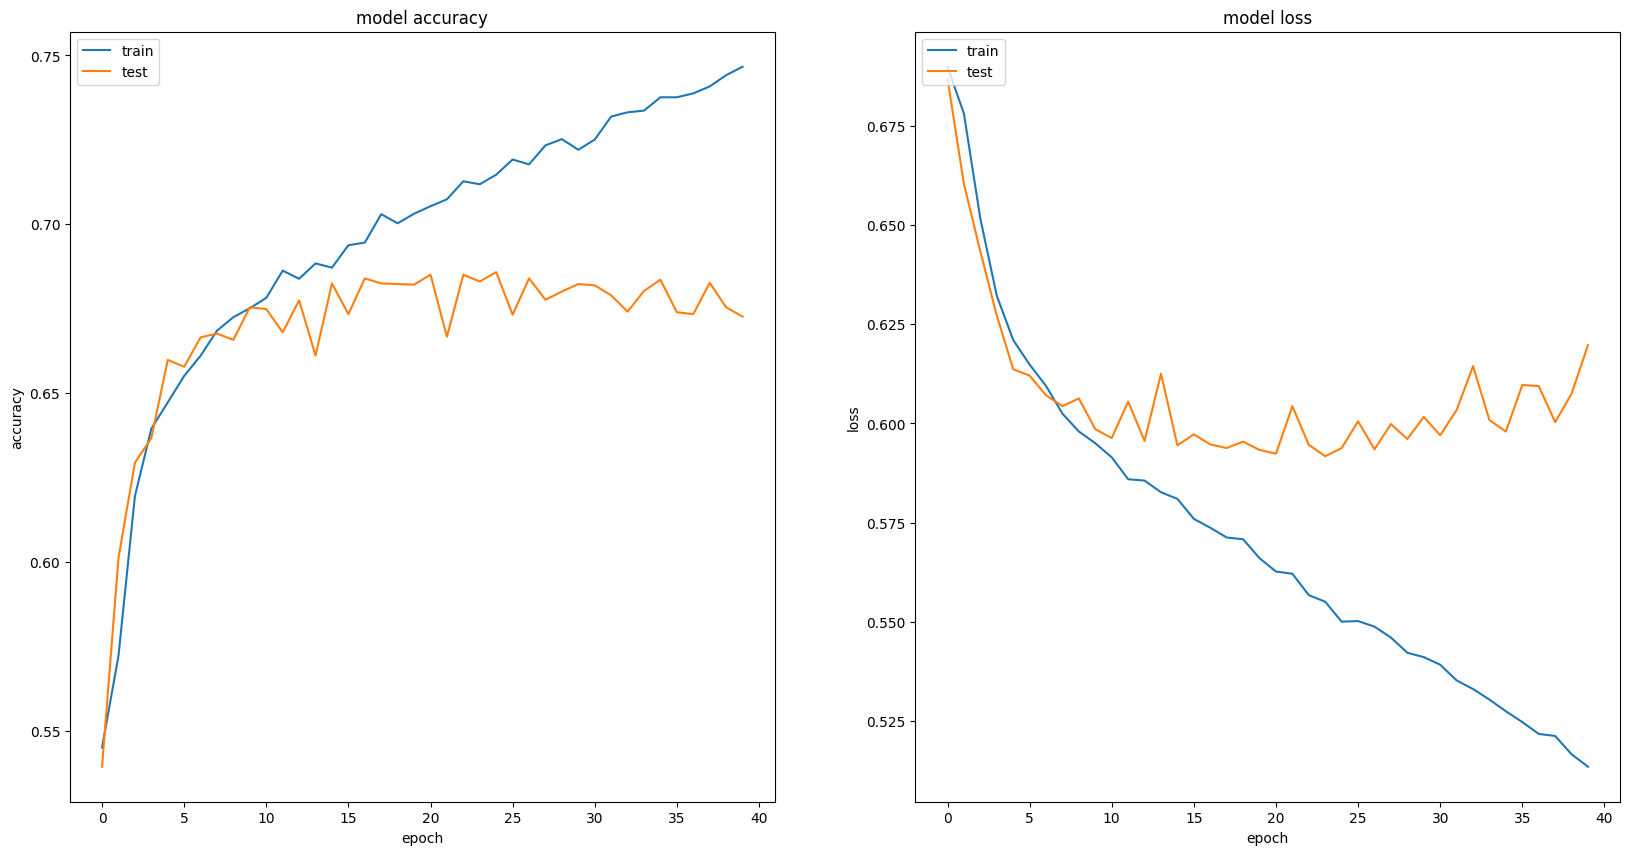

In [ ]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [ ]:
#Get loss
loss, _ = model.evaluate([dev_premises, dev_hypotheses], dev_labels)
print("\nTest score/loss:", loss)

211/211 [==============================] - 3s 15ms/step - loss: 0.6245 - accuracy: 0.6696

Test score/loss: 0.6245318651199341


In [ ]:
predicted_labels = model.predict(x=[dev_premises, dev_hypotheses])
predicted_labels = (predicted_labels > 0.5).astype(int)

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.array(dev_labels), predicted_labels=np.array(predicted_labels))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()